In [51]:
import tskit
import tszip
import numpy as np
import pandas as pd
import stdpopsim
from numpy.random import default_rng
import msprime
import pyreadr
import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [3]:
BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

In [ ]:
n_anc = 3

In [39]:
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/SUMMARY"

In [8]:
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/true_local_ancestry.site_matrix.npz"

In [12]:
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/RFMix2/rfmix2.fb.tsv'

In [ ]:
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/long_run/MOSAIC/la_probabilites.3way_1-200_22-22_2800_60_0.99_100.RData'

In [63]:
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC/la_probabilites.RData"

In [ ]:
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf.gz'

# TODO
    - move to Snakemake
    - write out the diploid ancestry dosage matrices
    - write out the accuracy for each in a file

In [60]:
def get_ancestry_dosage(arr, n_anc=3):
    assert (n_anc==3)
    a0 = arr[:, 0::3] # should be views
    a1 = arr[:, 1::3]
    a2 = arr[:, 2::3]
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=np.half)
    anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
    anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
    anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    return anc_dosage

In [5]:
def plot_ancestry_dosage(pred_dosage, start_index, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    fig, ax = plt.subplots(figsize = (12, 4), nrows = 3, sharex=True, sharey=True)
    l0, = ax[0].plot(pred_dosage[:, start_index+0], c='b')
    l1, = ax[1].plot(pred_dosage[:, start_index+1], c='orange')
    l2, = ax[2].plot(pred_dosage[:, start_index+2], c='green')
    plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])
    ax[0].set_title('Ancestry dosage')
    ax[2].set_xlabel('Site number ')
    
    if reference_dosage is not None:
        l0, = ax[0].plot(reference_dosage[:, start_index+0], c='b', alpha=.5, ls='--')
        l1, = ax[1].plot(reference_dosage[:, start_index+1], c='orange', alpha=.5, ls='--')
        l2, = ax[2].plot(reference_dosage[:, start_index+2], c='green', alpha=.5, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)

In [6]:
def r2_ancestry_dosage(true_dosage, pred_dosage, nanc):
    if type(pred_dosage) is pd.core.frame.DataFrame:
        pred_dosage = pred_dosage.values
    per_anc = []
    for i in range(nanc):
        per_anc.append(
            r2_score(
                y_true=true_dosage[:,i::3].ravel(),
                y_pred=pred_dosage[:,i::3].ravel()
            )
        )
    per_ind = []
    for i in range(int(true_dosage.shape[1]/nanc)):
        per_ind.append(
            r2_score(
                y_true=true_dosage[:, i*nanc:i*nanc+nanc].ravel(),
                y_pred=pred_dosage[:, i*nanc:i*nanc+nanc].ravel()
            )
        )
    
    return(per_anc, per_ind)

# True ancestry

In [7]:
def load_true_la(path):
    return np.load(path)['arr']

def get_true_anc_dosage(true_la, n_anc):
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    aa = np.arange(true_la[:, ::2].shape[1])*n_anc+true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1])*n_anc+true_la[:, 1::2]
    np.put_along_axis(hap1, aa, 1, axis=1)
    np.put_along_axis(hap2, bb, 1, axis=1)
    return hap1+hap2

## Load in the probablistic output of each method
Data frame with one row per site, 

Only every 5 sites represented in this file - not sure if it will always be intervals of 5 sites

After the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [11]:
def load_rfmix_fb(path):
    rfmix_res = pd.read_csv(path, sep='\t', comment='#')
    # expand out to each site
    rfmix_res = np.repeat(rfmix_res.iloc[:, 4:].values, [5], axis = 0)
    return rfmix_res

In [36]:
def load_bmix(path):
    csv_path = path.replace('.vcf.gz', '.csv')
    !{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {path} > {csv_path}
    bmix = pd.read_csv(csv_path, header=None)
    bmix = bmix.dropna(axis=1)
    return(bmix.iloc[:,2:].values)

In [61]:
def load_mosaic(path):
    mr = pyreadr.read_r(path)['arr'].astype(np.half)
    mr = mr.to_numpy().T.reshape((mr.shape[2],-1), order='C')
    return mr

In [66]:
pyreadr.read_r(mosaic_path)

OrderedDict()

In [9]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

In [13]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path))
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)

In [64]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path))
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)

KeyError: 'arr'

In [37]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath))
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)

In [58]:
## Write R2 tables
with open(os.path.join(base_path, 'R2_score.ancestry.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'anc_{x}' for x in range(nanc)]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_anc_r2])  + '\n')
    
with open(os.path.join(base_path, 'R2_score.individuals.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'ind_{x}' for x in range(len(bmix_ind_r2))]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_ind_r2])  + '\n')

In [ ]:
assert False

[0.974887791486827, 0.9576812785319607, 0.9656232198425216]

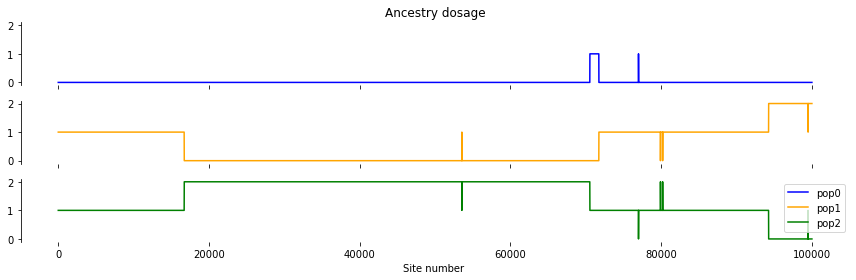

In [10]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=None)

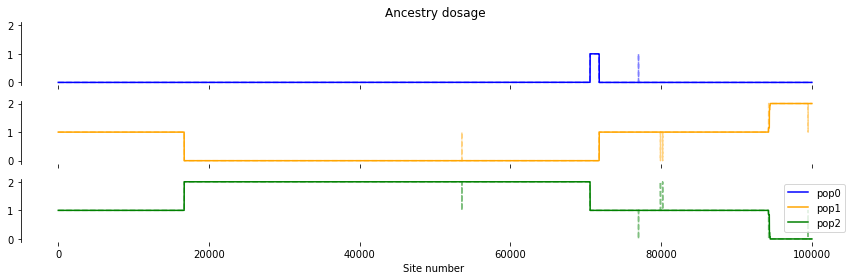

In [14]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

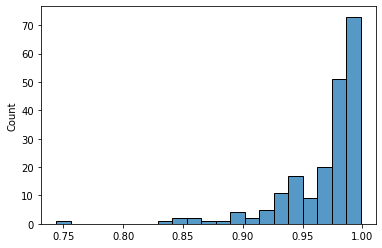

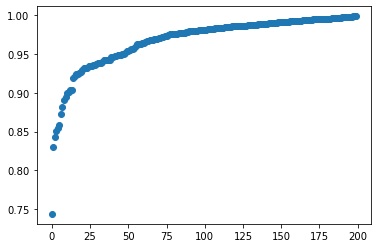

(0.9660640966204364, 0.9674451863592934)

In [15]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (ancestry) has an entry. 

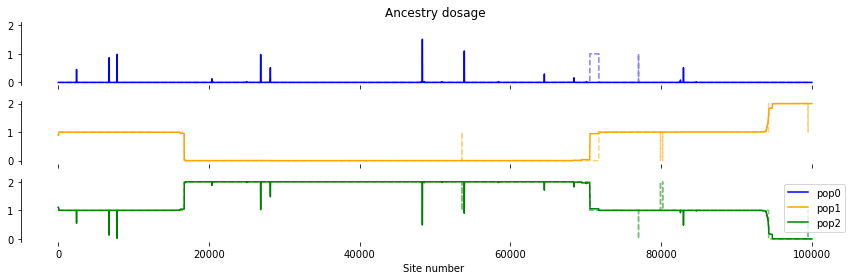

In [35]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

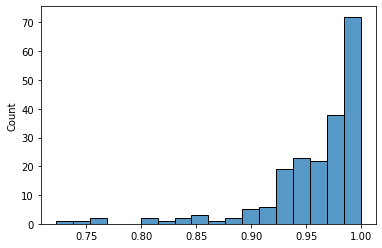

(0.9527561151967023, 0.9574373895594066)

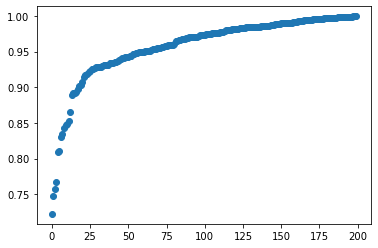

In [18]:
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(mosaic_ind_r2)
plt.show()
plt.scatter(np.arange(len(mosaic_ind_r2)), sorted(mosaic_ind_r2))
np.mean(mosaic_anc_r2), np.mean(mosaic_ind_r2)

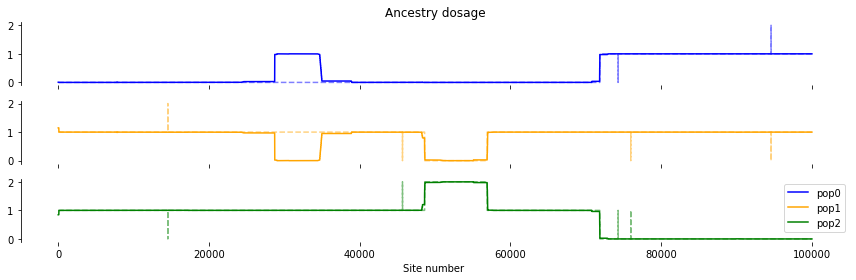

In [19]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

# bmix

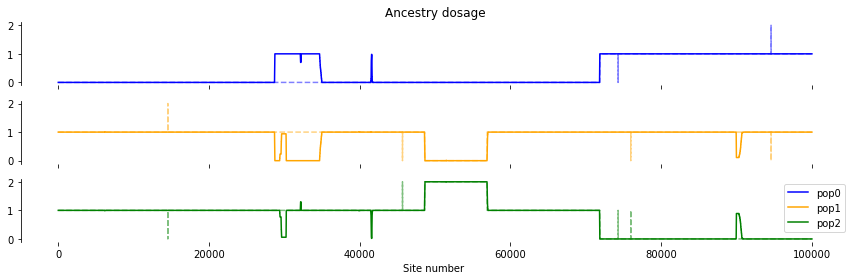

In [38]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [21]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [22]:
bmix = pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)
bmix = bmix.dropna(axis=1)
bmix = bmix.iloc[:,2:]
bmix_anc_dosage = get_ancestry_dosage(bmix.values)

In [23]:
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

(0.9788792486156549, 0.9797811616797916)

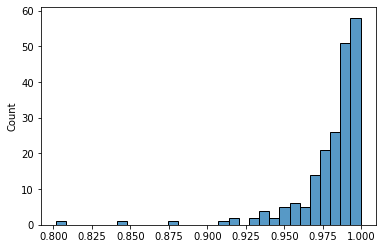

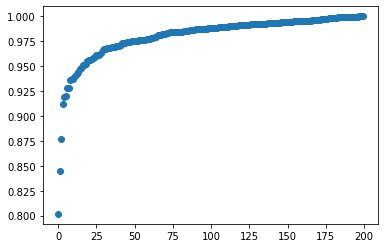

In [24]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
np.where(bmix_ind_r2 == np.min(bmix_ind_r2))
plt.show()

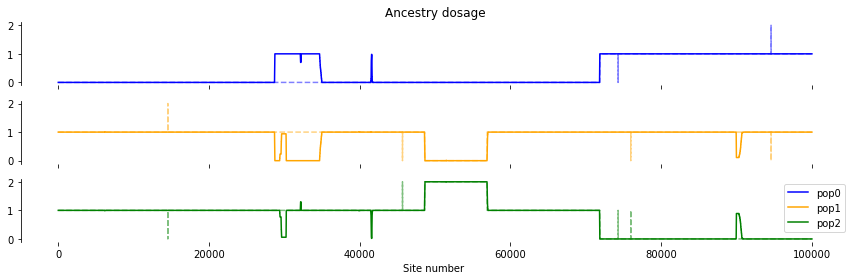

In [25]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

## There is not a huge correlation in the indiviudal level accuracy of the various methods here

In [26]:
r2_df = pd.DataFrame(data = {'bmix':bmix_ind_r2, 'rfmix':rfmix_ind_r2, 'mosaic':mosaic_ind_r2})

In [27]:
pearsonr(r2_df['bmix'], r2_df['mosaic'])[0]**2, pearsonr(r2_df['bmix'], r2_df['rfmix'])[0]**2, pearsonr(r2_df['mosaic'], r2_df['rfmix'])[0]**2

(0.08360726201928743, 0.3831561831675088, 0.1638570657100257)

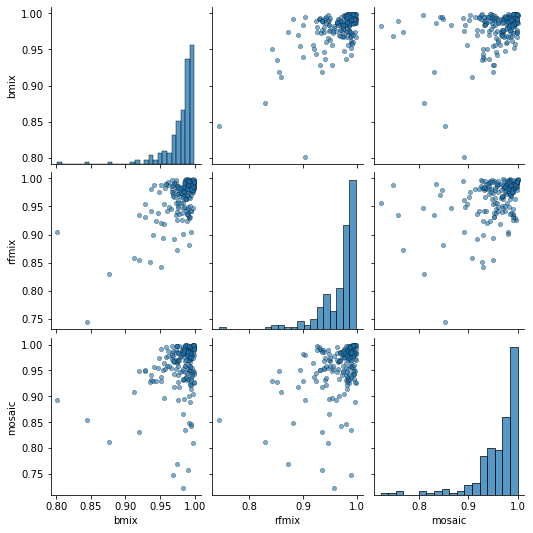

In [28]:
sns.pairplot(r2_df,
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'})

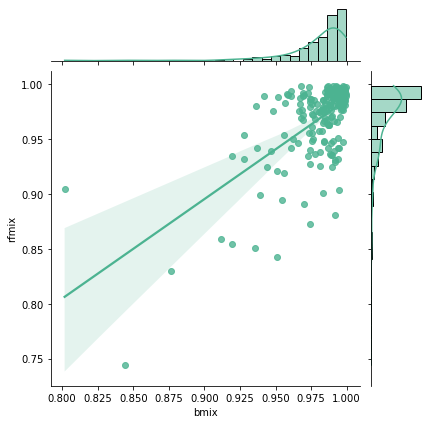

In [29]:
sns.jointplot(data = r2_df, x='bmix', y='rfmix', color="#4CB391", kind="reg")